In [68]:
import sys

sys.path.insert(0, '/home/jianx/search-exposure/')
import faiss
import forward_ranker.load_data as load_data
from forward_ranker.utils import print_message
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

PASSAGE_DICT_PATH = "/datadrive/jianx/data/passages.dict"
QUERY_TRAIN_DICT_PATH = "/datadrive/jianx/data/queries_train.dict"

# Queries plain text: queries.train.tsv
# Passages plain text: collection.tsv
QUERIES_TEXT_PATH = "/datadrive/jianx/data/queries.train.tsv"
PASSAGES_TEXT_PATH = "/datadrive/jianx/data/collection.tsv"

In [32]:
obj_reader = load_data.obj_reader
obj_writer = load_data.obj_writer

RANK = 10

In [3]:
print_message("Loading embeddings.")
passage_embeddings = obj_reader("/home/jianx/results/passage_0__emb_p__data_obj_0.pb")
query_train_embeddings = obj_reader("/home/jianx/results/query_0__emb_p__data_obj_0.pb")
query_train_mapping = obj_reader("/datadrive/jianx/data/annoy/100_ance_query_train_map.dict")
pid_mapping = obj_reader("/datadrive/jianx/data/annoy/100_ance_passage_map.dict")

[Aug 06, 00:20:09] Loading embeddings.


In [4]:
dim = passage_embeddings.shape[1]
passage_index = faiss.IndexFlatIP(dim)
passage_index.add(passage_embeddings)
query_index = faiss.IndexFlatIP(dim)
query_index.add(query_train_embeddings)

In [5]:
def load_tsv_dict(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split("\t")
            indexid = int(tokens[0])
            text = tokens[1].rstrip()
            my_dict[indexid] = text
            line = file.readline()
    return my_dict

In [6]:
queries_text_dict = load_tsv_dict(QUERIES_TEXT_PATH)
passages_text_dict = load_tsv_dict(PASSAGES_TEXT_PATH)

In [7]:
# Randomly pick a passage
# pick top 100 nearest queries
# For each query, 
# find nearest 100 passages
# record rank if the original passage is within top 100
# otherwise, record as 0

In [46]:
rd_index = random.randint(0, passage_embeddings.shape[0])
p_embed = passage_embeddings[rd_index]
pid = pid_mapping[rd_index]
print("{}:{}".format(pid, passages_text_dict[pid]))

1704661:There was no better parental bribe in the '90s than a trip to McDonald's, if only for the promise of a Happy Meal toy. If you clean your room, we'll go to McDonald's. Done. If you do well on your spelling test, we'll go to McDonald's. You got it, Mom. If you don't fight with your brother for an entire week, we'll go to McDonald's.


In [47]:
near_scores_q, near_queries = query_index.search(np.array([p_embed]), RANK)

In [48]:
rank_list = {}
score_list = {}
for i in range(RANK):
    q = near_queries[0,i]
    qid = query_train_mapping[q]
    print("{}: {}".format(qid, queries_text_dict[qid]))
    near_scores_p, near_passages = passage_index.search(np.array([query_train_embeddings[q]]), RANK)
    temp_rank = None
    for j in range(RANK):
        if rd_index == near_passages[0,j]:
            temp_rank = j
            temp_score = near_scores_p[0,j]
            break
    if not temp_rank:
        temp_rank = 1000
        temp_score = -1000
        print("Not in top {}".format(RANK))
    else:
        print(temp_rank, temp_score)
    rank_list[qid] = temp_rank
    score_list[qid] = temp_score

333808: how old do you have to be to work at mcdonalds
1000 -1000
333879: how old do you have to work at mcdonalds
1000 -1000
333207: how old do i have to be to work at mcdonald's
1000 -1000
333930: how old do you need to be to work at mcdonalds
1000 -1000
333865: how old do you have to be to work mcdonalds
1000 -1000
28091: at what age can you work at mcdonalds
1000 -1000
908942: what toy is in the happy meal at mcdonalds
1000 -1000
337263: how old to work at mcdonalds
1000 -1000
551005: what age do you have to be to work at mcdonalds
1000 -1000
443019: los cabos mexico where i can stay with kids and swim with dolphins
1000 -1000


In [90]:
def display_random_example(RANK, RANK_f, output = None, random_option = None):
    if random_option:
        rd_index = random_option
    else:
        rd_index = random.randint(0, passage_embeddings.shape[0])
    p_embed = passage_embeddings[rd_index]
    pid = pid_mapping[rd_index]
    print("{} ({}):{}".format(pid, rd_index, passages_text_dict[pid]))
    near_scores_q, near_queries = query_index.search(np.array([p_embed]), RANK)
    rank_list = {}
    score_list = {}
    for i in range(RANK):
        q = near_queries[0,i]
        qid = query_train_mapping[q]
        print("{}: {}".format(qid, queries_text_dict[qid]))
        near_scores_p, near_passages = passage_index.search(np.array([query_train_embeddings[q]]), RANK_f)
        temp_rank = None
        for j in range(RANK_f):
            if rd_index == near_passages[0,j]:
                temp_rank = j
                temp_score = near_scores_p[0,j]
                break
        if not temp_rank:
            temp_rank = 1000
            temp_score = -1000
            print("Not in top {}".format(RANK_f))
        else:
            print(temp_rank, temp_score)
        rank_list[qid] = [temp_rank,i]
        score_list[qid] = temp_score
    if output:
        return rank_list, score_list

In [50]:
display_random_example(10)

2736776:The donut or temp spare tire became popular in the 90s as a temporary replacement for blown or damaged tires. Made for light travel and, ideally, short distances, the temp spare can get you out of a tough spot and back on track to safety if you have trouble on the road.
1180119: how long does temporary spare tire last
Not in top 10
681888: what is a donut?
Not in top 10
674107: what is a bald tire?
Not in top 10
848033: what is the standard donut size
Not in top 10
948791: when donuts were invented
Not in top 10
681886: what is a donut peach
Not in top 10
681875: what is a donabe
Not in top 10
1157346: what is a trivet for
Not in top 10
700257: what is a skort
Not in top 10
1147514: daylight donuts originated where
Not in top 10


In [54]:
display_random_example(10,100)

2755790:65.77 Acres Union Mills, Rutherford County, North Carolina. $1,399,000. The Discovery Center @ Queens Gap is an 8000 square foot, custom designed, multi-purpose facility on 65 prime mountain acres, located in the Blue Ridge Mountains, just off US Hwy 221 & I-40, near Asheville, Marion and Rutherfordton NC.
1003638: where was the cumberland iron works rolling mill in stewart county tennessee
30 709.9934
996511: where is the madison mills area in columbus ohio
49 707.7818
1182301: hoa fee in quail meadow, martin downs golf club
Not in top 100
548186: wells fargo locations in colonial heights va
33 707.6195
804142: what is the address for the winn-dixie on fort caroline road
42 707.25574
474874: phone number to central sunbelt federal credit union on westover drive in hattiesburg mississippi
Not in top 100
980420: where is concord mills?
33 707.1439
1171571: price of gmc canyon pickup
Not in top 100
727955: what is caresource bronze indiana
28 706.8163
604058: what county is cedar

In [55]:
display_random_example(10,100)

6793030:Health Savings Account Advantages: Contributions to the HSA are 100% deductible (up to the legal limit) â just like an IRA. Withdrawals to pay qualified medical expenses, including dental and vision, are never taxed.
687187: what is a hsa health savings account
Not in top 100
617273: what deductible qualifies for a HSA
66 707.3962
832817: what is the minimum deductible for an hsa
Not in top 100
50888: benefits of hsa accounts
26 706.4033
838847: what is the penalty for using hsa distributions to pay non-qualified expenses
Not in top 100
1032527: who is eligible for a health savings account
15 706.23895
22977: are hsa accounts tax free
15 705.8961
24154: are payments made for medical expenses from hsa taxable income
Not in top 100
686454: what is a health care savings account
Not in top 100
755985: what is hsa medical insurance
Not in top 100


In [96]:
# 7920566 (6326271)
rankings, scores = display_random_example(100,100,True,6326271)

7920566 (6326271):Clarke County is a county located in the U.S. state of Mississippi. As of the 2010 census, the population was 16,732. Its county seat is Quitman. Clarke County is named for Joshua G. Clarke, the first Mississippi state chancellor and judge. The county is part of the Meridian, MS Micropolitan Statistical Area.
604486: what county is coleman tx
33 707.8198
94481: coleman texas is in what county
69 706.96155
839828: what is the population of coleman tx
24 706.86816
839844: what is the population of cullman county alabama
67 706.8543
611735: what county is quitman tx in
52 706.74396
604836: what county is cullman alabama
58 706.7277
611734: what county is quitman tx
55 706.5894
477447: population of clark county
27 706.4069
986616: where is lincoln county
Not in top 100
604771: what county is creighton pa
Not in top 100
604485: what county is coleman ok in
40 705.62384
601875: what county chinle az
7 705.43024
603925: what county is carlton ga
Not in top 100
604298: what 

In [94]:
# 2798791 (2021611)
rankings2, scores2 = display_random_example(100,100,True)

2798791 (2021611):Hannity, a Fox News programming staple since 2008, will be replaced by a new, yet-to-be-named animated news and current events show produced by Seth MacFarlane, creator and producer of Family Guy, and American Dad. âThis is a business,â remarked Ailes, when questioned outside Fox News Headquarters in New York. â Hannity was great, it performed well, but numbers were going down. People get tired of hearing the same old complaints. Maybe weâll open up a spot for Sean if Hillary gets elected.
495428: shameless is on what channel
Not in top 100
1137347: who was sunshine on hee haw
Not in top 100
1145268: what tv shows has seth macfarlane been on
19 705.90704
1046863: who played johnny fontaine in godfather
Not in top 100
1053593: who was charles henry wilson from hull
Not in top 100
495431: shameless what channel
95 705.12744
956431: when was Aerosmith and Tom hanks were on saturday night live
Not in top 100
1046451: who played calamity jane in deadwood
Not in top

In [100]:
# rankings3, scores3
rankings3, scores3 = display_random_example(100,100,True)

3916969 (2609168):Kepler-62f is only 40 percent larger than Earth, making it the exoplanet closest to the size of our planet known in the habitable zone of another star. Kepler-62f is likely to have a rocky composition.
1154318: what is kepler exoplanet data
11 709.018
763065: what is kepler planet
19 707.66364
1149176: what is the smallest outer planet
92 706.6144
1017509: which planet is the brightest in the sky
Not in top 100
742270: what is earth's outer core thickness
Not in top 100
1017495: which planet is closest in size to earth
80 705.4254
1017513: which planet is the hottest in the solar system
Not in top 100
1017507: which planet is the brightest
Not in top 100
476117: pluto is the largest solar system object outside neptune
Not in top 100
1011978: which is the coldest planet
Not in top 100
209109: how big is earth's core
Not in top 100
235392: how hot are our planets
Not in top 100
820879: what is the farthest planet
Not in top 100
1017535: which planets are mostly ice
Not 

In [97]:
def visualize_score_rank(rankings, scores):
    rankings = list(rankings.values())
    scores = list(scores.values())
    rank_list = []
    score_list = []
    rank_list_p = []
    for i in range(len(rankings)):
        if rankings[i][0] != 1000:
            rank_list.append(rankings[i][0])
            score_list.append(scores[i])
            rank_list_p.append(rankings[i][1])
    plt.xlabel("Dot Product")
    plt.ylabel("Rank")
    plt.scatter(score_list, rank_list)
    plt.show()
    plt.xlabel("Rank in Nearest Neighbor List")
    plt.ylabel("Rank")
    plt.scatter(rank_list_p, rank_list)
    plt.show()

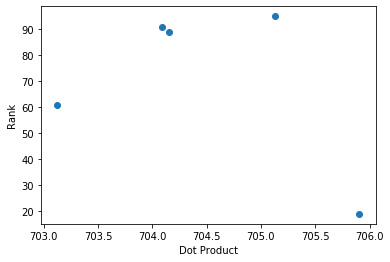

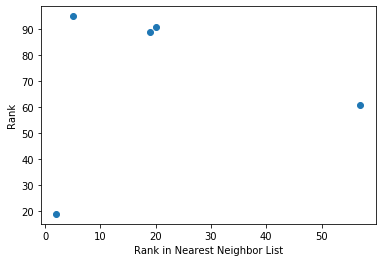

In [98]:
# 7920566 (6326271)
visualize_score_rank(rankings2, scores2)

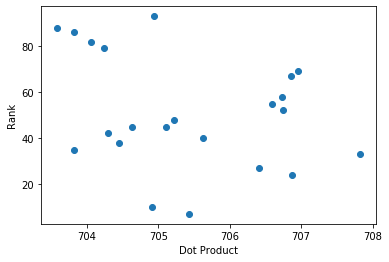

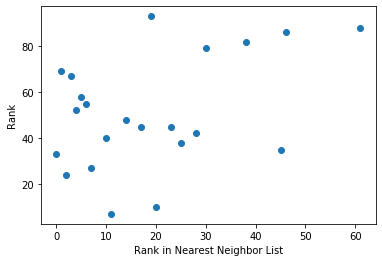

In [99]:
# 7920566 (6326271)
visualize_score_rank(rankings, scores)